# Sample 1 - Use Only Numeric to Predict

### Problem Statement

sample นี้จะใช้ข้อมูลที่เป็นตัวเลขทั่งหมดมาทดสอบว่าสามารถคาดเดาราคาของที่พักได้หรือไม่

# 1. Import Package

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("ggplot")
import json
import missingno as msno

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# 2. Import Data

In [113]:
df_district = pd.read_csv('Meterial/bangkok_district.csv')
df_train = pd.read_json('Meterial/train.json')
df_test = pd.read_json('Meterial/test.json')

# 3. EDA

### Check Null Value

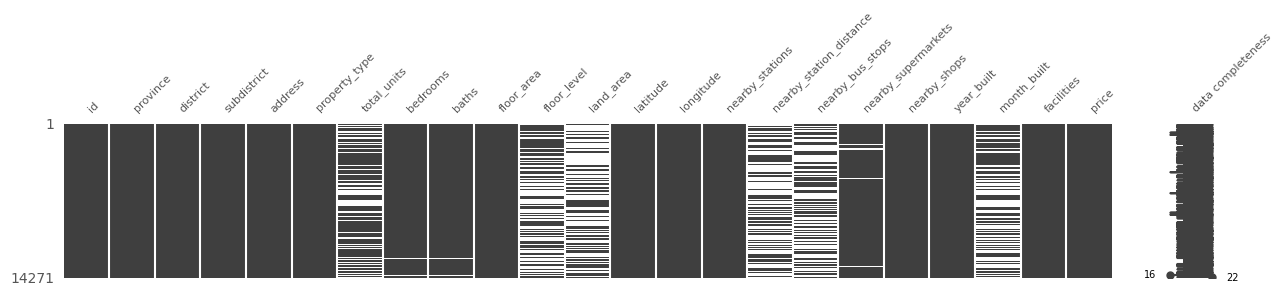

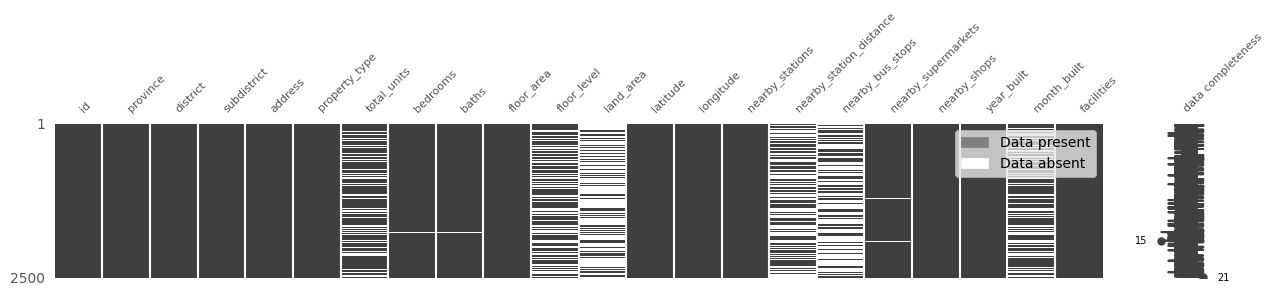

In [114]:
#Check Null Value
msno.matrix(df_train, figsize=(15,2),fontsize=8,labels="Data Train") ;
#plt.legend(['missing','not missing'], bbox_to_anchor=(1, 0.5))
msno.matrix(df_test, figsize=(15,2),fontsize=8,labels="Data Predict") ;
gray_patch = mpatches.Patch(color='gray', label='Data present')
white_patch = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray_patch, white_patch])

### Calculate Mean & Median

In [115]:
#Create Standard Mean for Null Value
unit_mean = df_train['total_units'].mean()
bed_mean = df_train['bedrooms'].mean()
baths_mean = df_train['baths'].mean()
super_mean = df_train['nearby_supermarkets'].mean()

In [116]:
#Create Standard Median for Null Value
unit_median = df_train['total_units'].median()
bed_median = df_train['bedrooms'].median()
baths_median = df_train['baths'].median()
super_median = df_train['nearby_supermarkets'].median()

### Check density of data

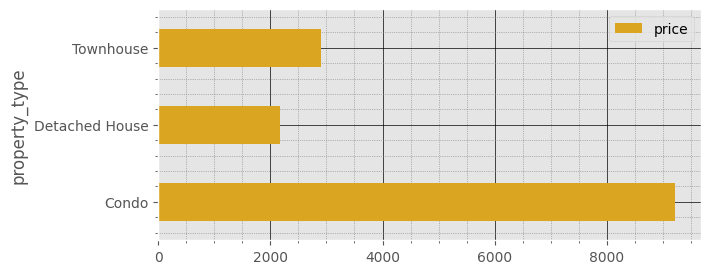

In [117]:
# Check Property Type VS Price
prop_type = df_train[['property_type','price']].groupby(['property_type']).count()
prop_type.plot(kind ='barh',figsize=(7,3), color='goldenrod')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

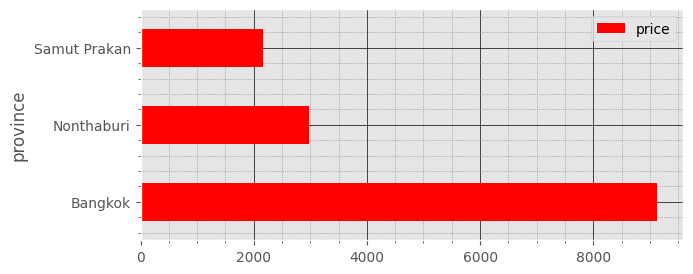

In [118]:
# Check Province Type VS Price
prop_type = df_train[['province','price']].groupby(['province']).count()
prop_type.plot(kind ='barh',figsize=(7,3), color='red')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

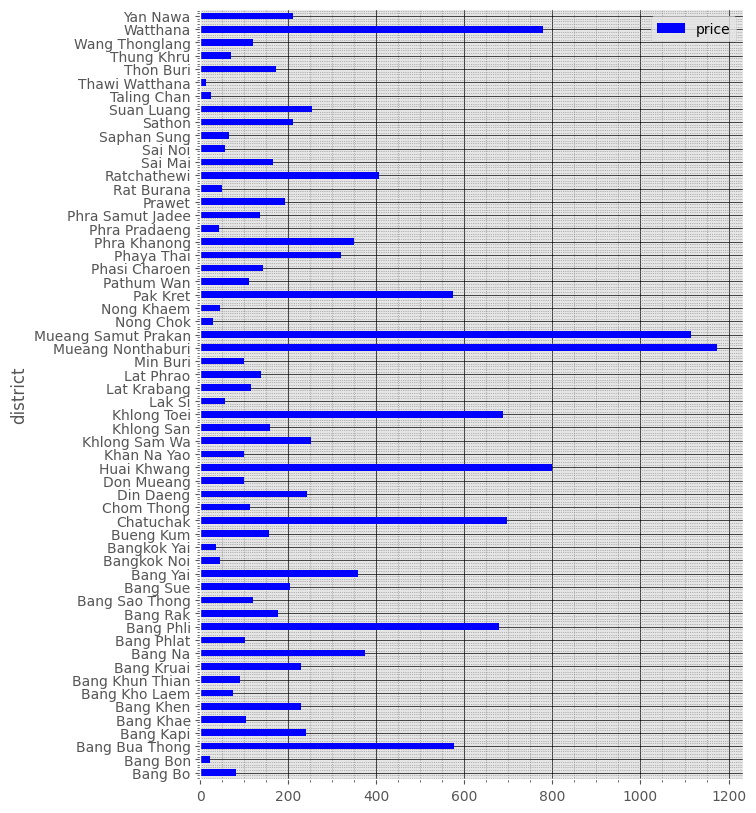

In [119]:
# Check District Type VS Price
prop_type = df_train[['district','price']].groupby(['district']).count()
prop_type.plot(kind ='barh',figsize=(7,10), color='blue')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

## Select Feature of data to train

In [120]:
# Data to train

data_train = df_train[['total_units','bedrooms','baths','floor_area','floor_level','nearby_supermarkets','nearby_shops','price']]
data_train["num_facility"] = df_train["facilities"].apply(len)

data_train.head()

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1383261266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["num_facility"] = df_train["facilities"].apply(len)


,total_units,bedrooms,baths,floor_area,floor_level,nearby_supermarkets,nearby_shops,price,num_facility
0,273.0,2.0,2.0,66,10.0,16.0,20,8500000,6
1,74.0,1.0,1.0,49,8.0,11.0,20,5900000,4
2,940.0,1.0,1.0,34,4.0,20.0,20,6290000,7
3,NaN,3.0,3.0,170,NaN,2.0,4,8900000,4
4,NaN,3.0,2.0,120,NaN,6.0,15,2390000,2


In [121]:
# Data to test

data_test = df_test[['id','total_units','bedrooms','baths','floor_area','floor_level','nearby_supermarkets','nearby_shops']]
data_test["num_facility"] = df_train["facilities"].apply(len)

data_test.head()

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/2625102873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["num_facility"] = df_train["facilities"].apply(len)


,id,total_units,bedrooms,baths,floor_area,floor_level,nearby_supermarkets,nearby_shops,num_facility
0,10317868,800.0,4.0,3.0,120,NaN,9.0,5,6
1,10885829,107.0,4.0,3.0,188,NaN,9.0,5,4
2,10765951,433.0,1.0,1.0,22,23.0,13.0,20,7
3,10003549,656.0,1.0,1.0,41,5.0,16.0,20,4
4,10663026,1458.0,1.0,1.0,29,25.0,10.0,14,2


#### Function find near station and distanct

In [122]:
# Function find Near station and distanct !! if no station = NaN
def closest_station(station_list, return_value='station_name'):
    if type(station_list) != list:
        if return_value == 'station_name':
            return "NO STATION"
        elif return_value == 'station_distance':
            return np.nan
    else:
        if return_value == 'station_name':
            return station_list[0][0]
        elif return_value == 'station_distance':
            return station_list[0][1]

#data_train['distance'] = data_train.apply(distance, axis=1)
#data_train['closest_station_name'] = df_train.nearby_station_distance.apply(lambda x: closest_station(x, 'station_name'))
data_train['closest_station_distance'] = df_train.nearby_station_distance.apply(lambda x: closest_station(x, 'station_distance'))
data_test['closest_station_distance'] = df_test.nearby_station_distance.apply(lambda x: closest_station(x, 'station_distance'))


/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1512964605.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['closest_station_distance'] = df_train.nearby_station_distance.apply(lambda x: closest_station(x, 'station_distance'))
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1512964605.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['closest_station_distance'] = df_test.nearby_station_distance.apply(lambda x: closest_station(x, 'station_distance')

#### Change data type to Foat

In [123]:
# Data Train
data_train.floor_area = data_train.floor_area.astype(float)
data_train.nearby_shops = data_train.nearby_shops.astype(float)
data_train.num_facility = data_train.num_facility.astype(float)
data_train.closest_station_distance = data_train.closest_station_distance.astype(float)

# Data Test
data_test.floor_area = data_test.floor_area.astype(float)
data_test.nearby_shops = data_test.nearby_shops.astype(float)
data_test.num_facility = data_test.num_facility.astype(float)
data_test.closest_station_distance = data_test.closest_station_distance.astype(float)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/4183775274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.floor_area = data_train.floor_area.astype(float)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/4183775274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.nearby_shops = data_train.nearby_shops.astype(float)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/4183775274.py:4: SettingWithCopyWarning: 
A value is trying to be set 

In [124]:
data_train[data_train['num_facility']==0]

,total_units,bedrooms,baths,floor_area,floor_level,nearby_supermarkets,nearby_shops,price,num_facility,closest_station_distance
12,NaN,4.0,2.0,117.0,NaN,1.0,4.0,3600000,0.0,NaN
27,NaN,3.0,3.0,179.0,NaN,7.0,8.0,8580000,0.0,NaN
31,NaN,3.0,3.0,160.0,NaN,6.0,15.0,7890000,0.0,20.0
32,NaN,2.0,2.0,120.0,2.0,11.0,4.0,3708000,0.0,NaN
40,NaN,6.0,5.0,222.0,NaN,6.0,12.0,8700000,0.0,290.0
...,...,...,...,...,...,...,...,...,...,...
14248,NaN,3.0,3.0,150.0,NaN,8.0,3.0,5500000,0.0,NaN
14255,NaN,3.0,2.0,85.0,NaN,1.0,8.0,2590000,0.0,NaN
14257,NaN,4.0,2.0,100.0,NaN,7.0,10.0,2350000,0.0,NaN
14262,NaN,2.0,2.0,144.0,NaN,16.0,20.0,2990000,0.0,940.0


### Create Flag column : เพื่อบอกว่า fild นั้นมี หรือ ไม่มี

In [125]:
# Function Create Flag if selet field have value > 0 Then 1 Else 0
def flag_by_value (value):
    if value > 0:
        return 1
    else:
        return 0

In [126]:
# Apply the function to the entire DataFrame
data_train['flag_facility'] = data_train['num_facility'].apply(flag_by_value)
data_train['flag_station'] = data_train['closest_station_distance'].apply(flag_by_value)

data_test['flag_facility'] = data_test['num_facility'].apply(flag_by_value)
data_test['flag_station'] = data_test['closest_station_distance'].apply(flag_by_value)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/2146967705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['flag_facility'] = data_train['num_facility'].apply(flag_by_value)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/2146967705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['flag_station'] = data_train['closest_station_distance'].apply(flag_by_value)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/2146967705.py:5: SettingWit

### Replace NaN value to default 1 \
ใส่เฉพาะ field floor_level/bahts เนื่องจากในแต่ละที่พักยังไงก็ต้องมีห้องน้ำ ห้องนอน 1 ห้องเสมอ (จากข้อมูลไม่ได้มีประเภท "หอพัก")

In [127]:
# Replace Nan to 1 -- default of resident must have 1 floor and 1 baths
data_train['floor_level'] = data_train['floor_level'].fillna(1)
data_train['baths'] = data_train['baths'].fillna(1)

data_test['floor_level'] = data_test['floor_level'].fillna(1)
data_test['baths'] = data_test['baths'].fillna(1)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1475765182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['floor_level'] = data_train['floor_level'].fillna(1)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1475765182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['baths'] = data_train['baths'].fillna(1)
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1475765182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

### Cehck Multicollinearity

<Axes: >

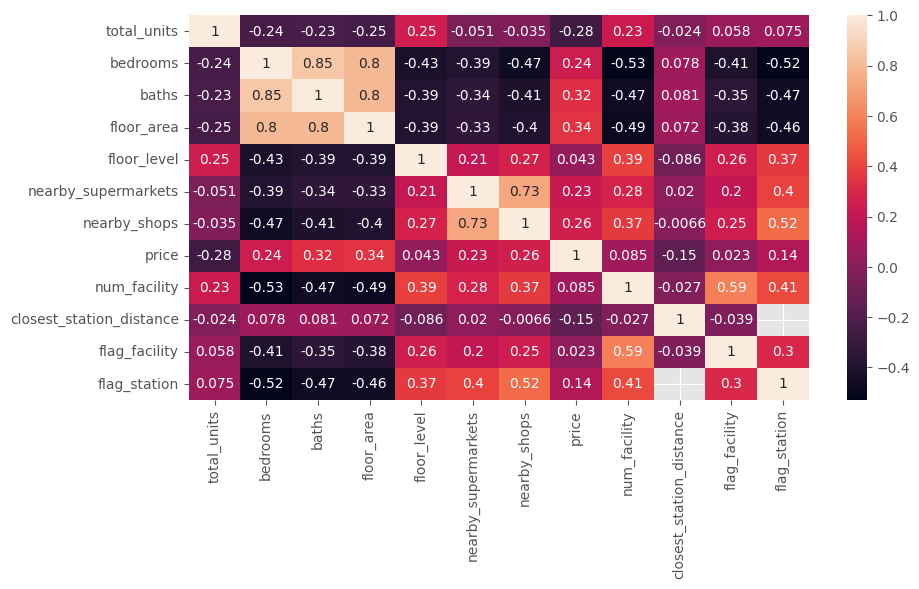

In [128]:
# Check multicollinearity
dfcor = data_train.corr()
plt.figure(figsize=(10,5))
sns.heatmap(data=dfcor,annot=True)

#### นำ Fild ที่ใกล้กันออก

In [129]:
columns = np.full((dfcor.shape[0],), True, dtype=bool)
for i in range(dfcor.shape[0]):
    for j in range(i+1, dfcor.shape[0]):
        if dfcor.iloc[i,j] >= 0.7 or dfcor.iloc[i,j] <=-0.7:
            if columns[j]:
                columns[j] = False
selected_columns = data_train.columns[columns]
df = data_train[selected_columns]

In [130]:
col = data_train.columns
print(col[1:])

Index(['bedrooms', 'baths', 'floor_area', 'floor_level', 'nearby_supermarkets',
       'nearby_shops', 'price', 'num_facility', 'closest_station_distance',
       'flag_facility', 'flag_station'],
      dtype='object')


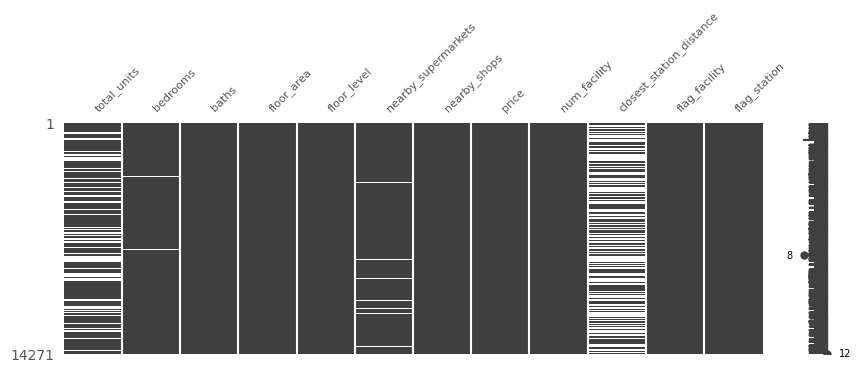

In [131]:
# ตรวจสอบ field อื่นๆว่ายังมีค่า Nan อยู่หรือไม่
msno.matrix(data_train, figsize=(10,3),fontsize=8) ;

### Histogram เพื่อดูค่าเบี่ยงเบน

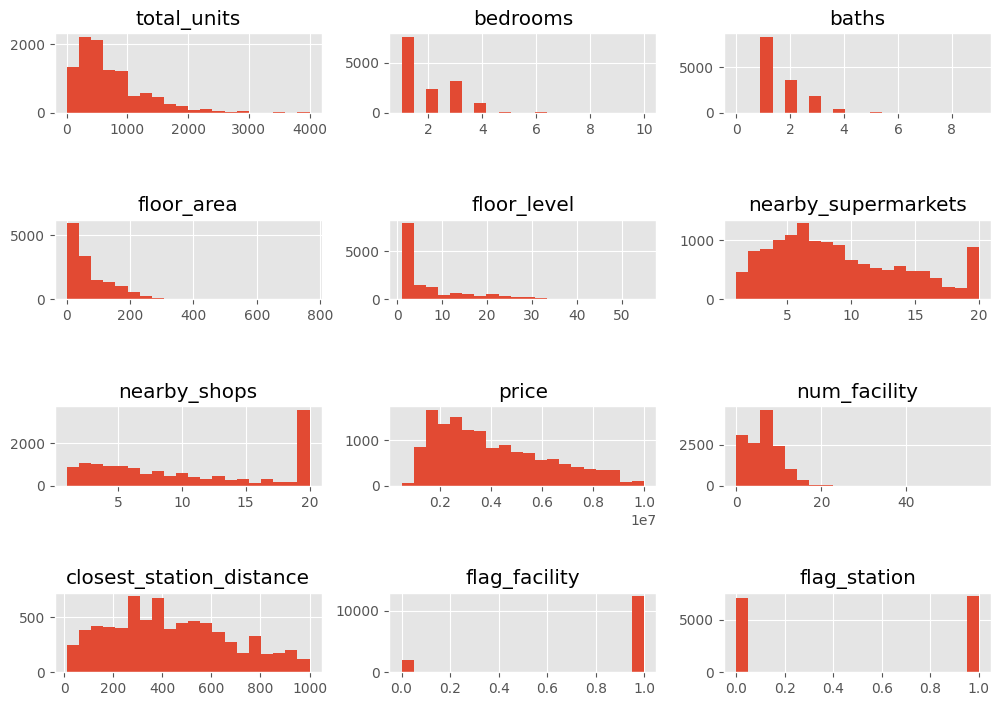

In [132]:
# Histrogram เพื่อดูค่าการเบี่ยงเบน
features = data_train.columns
fig, axs = plt.subplots(ncols=3, nrows=4, figsize = (10,7) )
index = 0
axs = axs.flatten()

for k in features:
    data_train[k].hist(bins=20, ax=axs[index])
    axs[index].set_title(k)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=3)

#### Result ช็อคแปป (´⊙ω⊙`)！

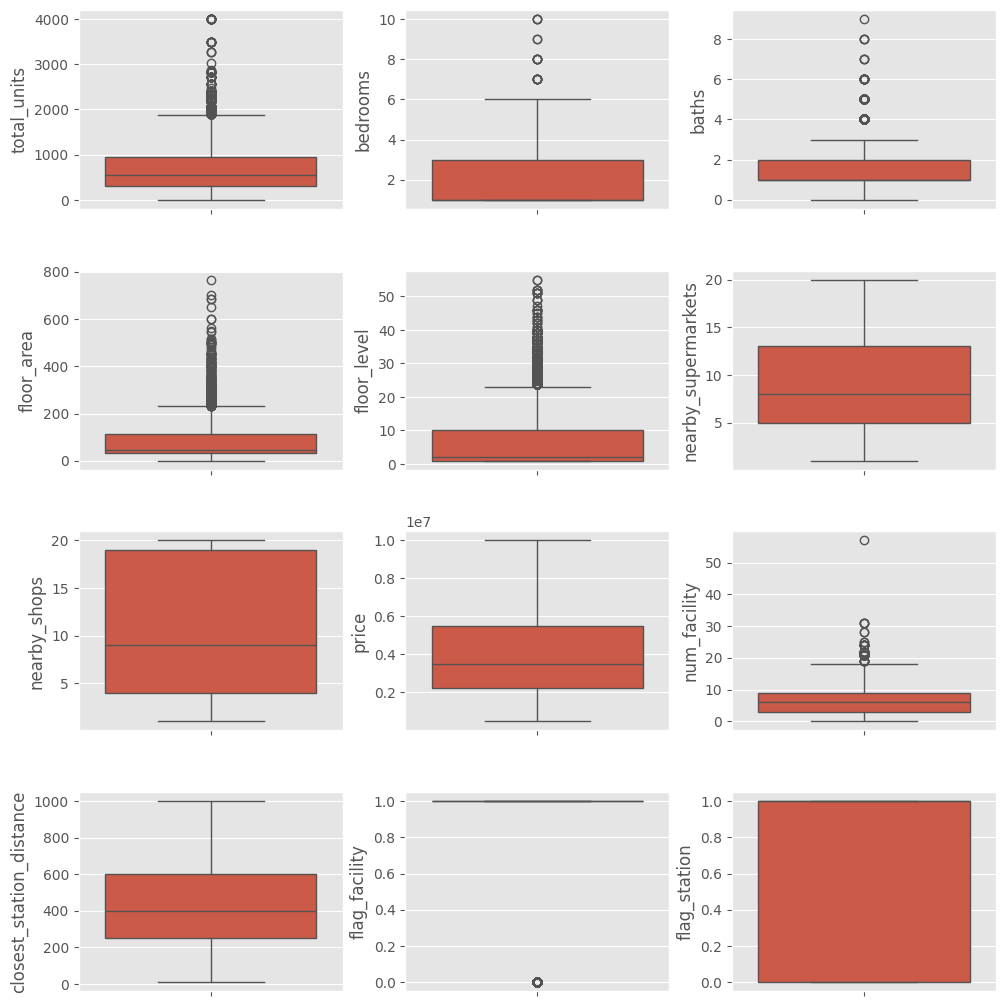

In [133]:
fig, axs = plt.subplots(ncols=3, nrows = 4,figsize = (10,10))
index = 0
axs = axs.flatten()

for k in features:
  sns.boxplot(y=k, data = data_train, ax=axs[index])
  index +=1
plt.tight_layout(pad=0.5, w_pad =0.5, h_pad=3)

#### พิจารณาความเบ้ด้วย Skewness

In [134]:
for k in features:
  print("{} skew is {}".format (k,data_train[k].skew()))

total_units skew is 1.6434669594565385
bedrooms skew is 1.0805618108242454
baths skew is 1.488740291411541
floor_area skew is 2.055653025798392
floor_level skew is 1.6836779134846793
nearby_supermarkets skew is 0.5413600521553236
nearby_shops skew is 0.2400887452700537
price skew is 0.6957356587109342
num_facility skew is 0.5774700579713746
closest_station_distance skew is 0.3599638545381449
flag_facility skew is -2.111733475091733
flag_station skew is -0.025931608958086848


#### พิจารณาความโด่งด้วย kurtosis

In [135]:
for k in features:
  print("{} kurtosis is {}".format (k,data_train[k].kurtosis()))

total_units kurtosis is 3.8780151982415774
bedrooms kurtosis is 1.1303531765687471
baths kurtosis is 2.68954762205058
floor_area kurtosis is 6.539441127531541
floor_level kurtosis is 2.461013074017905
nearby_supermarkets kurtosis is -0.7062183249428875
nearby_shops kurtosis is -1.477106885363219
price kurtosis is -0.46306654688511495
num_facility kurtosis is 1.8704518485817525
closest_station_distance kurtosis is -0.7127608530544123
flag_facility kurtosis is 2.4597629720642056
flag_station kurtosis is -1.9996078050348627


#### พิจารณา Feature ที่จะนำเข้ามาใช้ในการ predict โดยดูจาก skew,kurtosis ที่ใกล้ 0 ที่สุด \
closest_station_distance, num_facility, nearby_supermarkets

##### Pairepolt เพื่อดูความกระจาย ლ(́◉◞౪◟◉‵ლ)

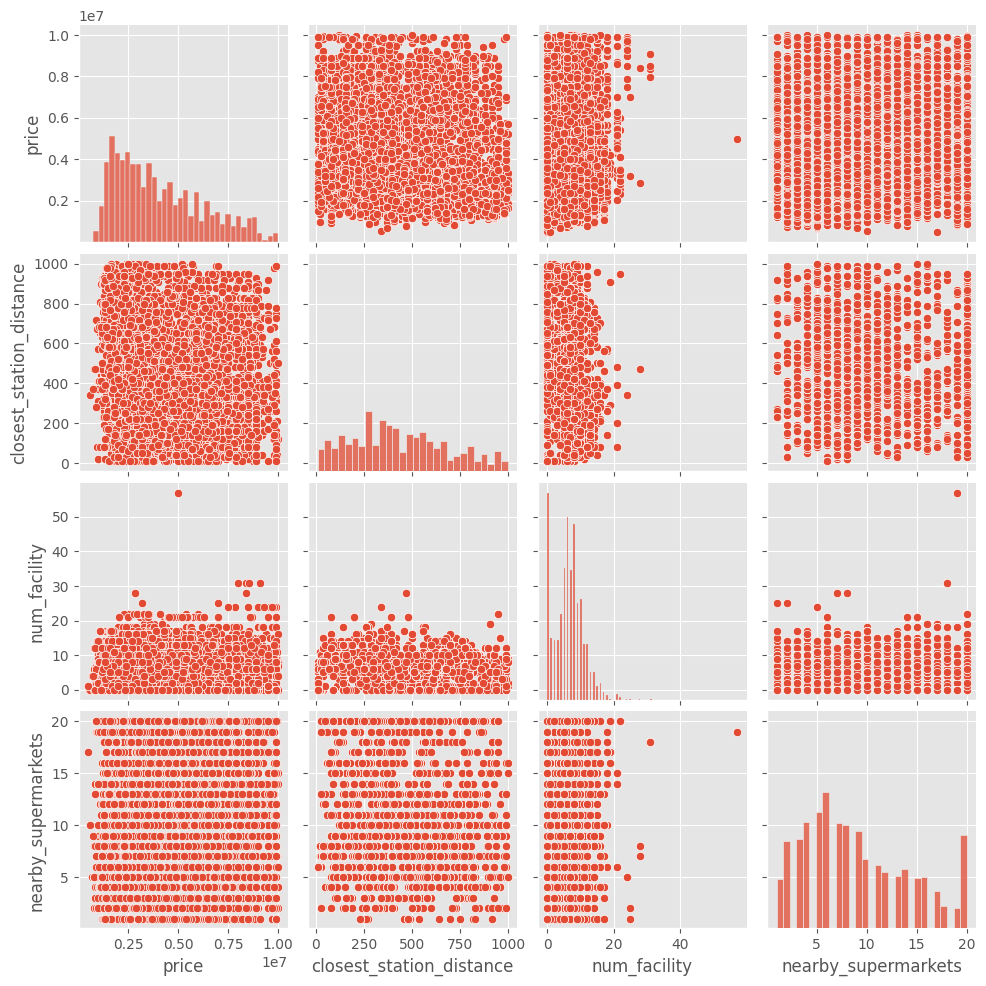

In [136]:
sns.pairplot(data_train[['price','closest_station_distance', 'num_facility','nearby_supermarkets']])

##### กำจัด Outlier

In [137]:
col_name = ['closest_station_distance', 'num_facility','nearby_supermarkets']
for column in col_name:
## Calculate Q1 and Q3
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
## data < Q3+1.5(Q3-Q1) and data > Q1-1.5(Q3-Q1)
    data_train = data_train[(data_train[column]<Q3+1.5*(Q3-Q1)) & (data_train[column]>Q1-1.5*(Q3-Q1))]

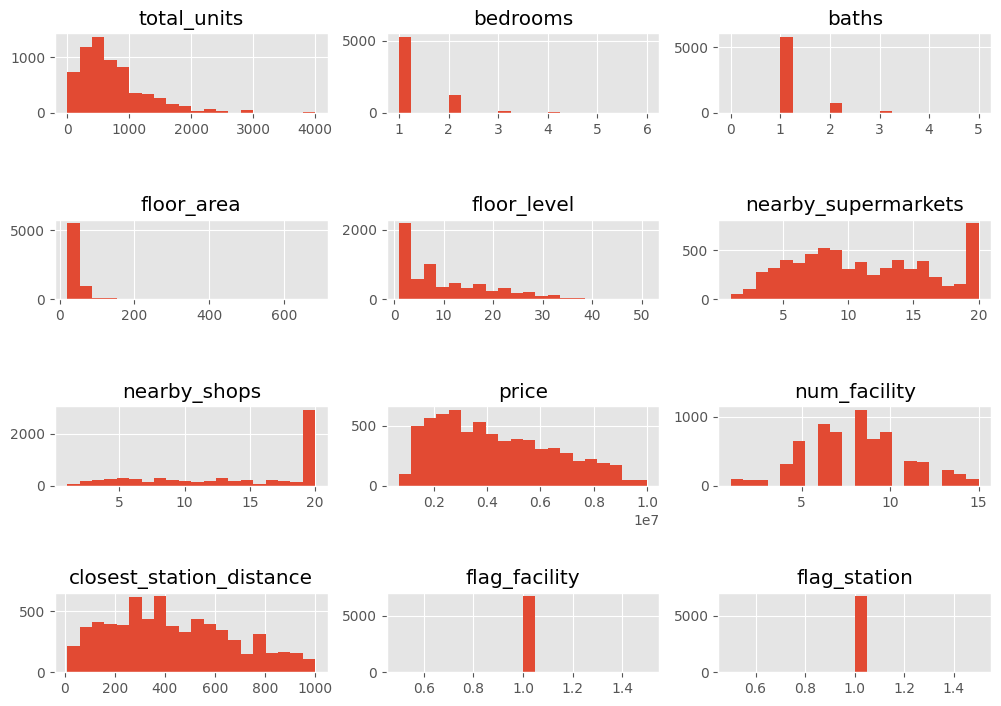

In [138]:
# Histrogram หลังจากที่มีการปรับ Outlier
features = data_train.columns
fig, axs = plt.subplots(ncols=3, nrows=4, figsize = (10,7) )
index = 0
axs = axs.flatten()

for k in features:
    data_train[k].hist(bins=20, ax=axs[index])
    axs[index].set_title(k)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=3)

##### Price เมื่อเปรียบเทียบกับข้อมูลอื่นๆ

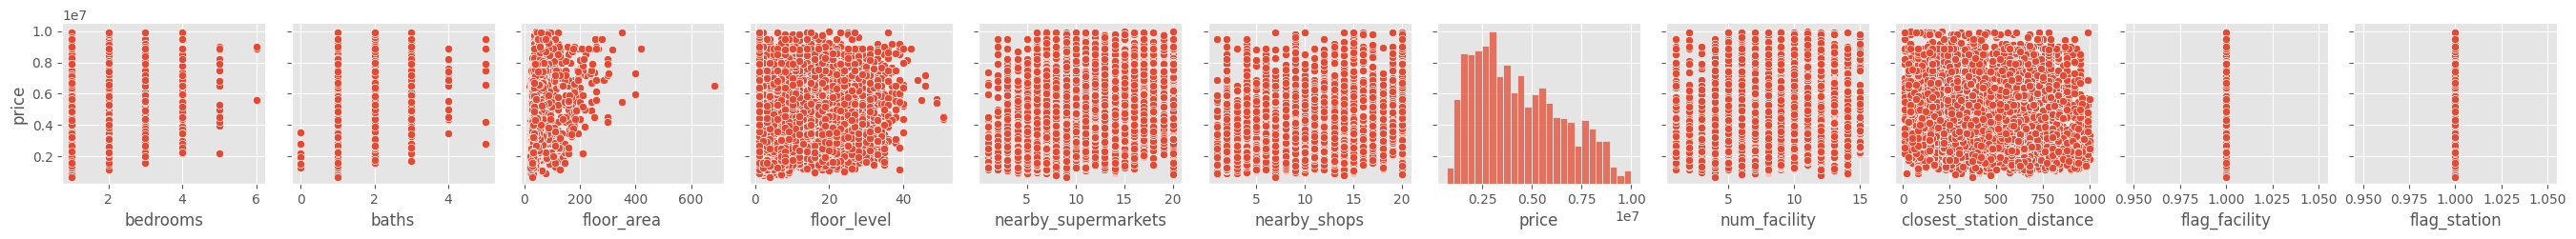

In [139]:
pp = sns.pairplot(data=data_train,
                  y_vars=['price'],
                  x_vars=col[1:])

##### KNN Imputer เพื่อแทนค่าของ Total Unit ที่ยังเป็น NaN

In [140]:
# ลองใช้ KNNImputer เพื่อแทนค่าที่ว่าง โดยดูจาก row ข้างเคียง
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5) 

In [141]:
# แทนค่า total_units ที่ว่าง
data_train['imputed_column'] = imputer.fit_transform(data_train[['total_units']])
data_test['imputed_column'] = imputer.fit_transform(data_test[['total_units']])

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1751547469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['imputed_column'] = imputer.fit_transform(data_test[['total_units']])


In [142]:
# total_units - แทนที่ field จริงด้วย dummy ที่ gen ขึ้นมา
data_train['total_units'] = data_train['imputed_column']
data_train.drop(columns=['imputed_column'], inplace=True)

data_test['total_units'] = data_test['imputed_column']
data_test.drop(columns=['imputed_column'], inplace=True)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/43690259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['total_units'] = data_test['imputed_column']
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/43690259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(columns=['imputed_column'], inplace=True)


In [143]:
# แทนค่า bedrooms ที่ว่าง
data_train['imputed_column'] = imputer.fit_transform(data_train[['bedrooms']])
data_test['imputed_column'] = imputer.fit_transform(data_test[['bedrooms']])

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/454930376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['imputed_column'] = imputer.fit_transform(data_test[['bedrooms']])


In [144]:
# bedrooms - แทนที่ field จริงด้วย dummy ที่ gen ขึ้นมา
data_train['bedrooms'] = data_train['imputed_column']
data_train.drop(columns=['imputed_column'], inplace=True)

data_test['bedrooms'] = data_test['imputed_column']
data_test.drop(columns=['imputed_column'], inplace=True)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/3370338605.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['bedrooms'] = data_test['imputed_column']
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/3370338605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(columns=['imputed_column'], inplace=True)


In [145]:
data_test['imputed_column'] = imputer.fit_transform(data_test[['nearby_supermarkets']])
data_test['nearby_supermarkets'] = data_test['imputed_column']
data_test.drop(columns=['imputed_column'], inplace=True)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/3917330049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['imputed_column'] = imputer.fit_transform(data_test[['nearby_supermarkets']])
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/3917330049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['nearby_supermarkets'] = data_test['imputed_column']
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/3917330049.py:3: SettingWithCopyWarning: 
A

In [146]:
data_test['imputed_column'] = imputer.fit_transform(data_test[['closest_station_distance']])
data_test['closest_station_distance'] = data_test['imputed_column']
data_test.drop(columns=['imputed_column'], inplace=True)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1416444124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['imputed_column'] = imputer.fit_transform(data_test[['closest_station_distance']])
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1416444124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['closest_station_distance'] = data_test['imputed_column']
/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_3717/1416444124.py:3: SettingWithCopyW

#### Check NaN Value ครั้งสุดท้าย

In [147]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6695 entries, 0 to 14270
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_units               6695 non-null   float64
 1   bedrooms                  6695 non-null   float64
 2   baths                     6695 non-null   float64
 3   floor_area                6695 non-null   float64
 4   floor_level               6695 non-null   float64
 5   nearby_supermarkets       6695 non-null   float64
 6   nearby_shops              6695 non-null   float64
 7   price                     6695 non-null   int64  
 8   num_facility              6695 non-null   float64
 9   closest_station_distance  6695 non-null   float64
 10  flag_facility             6695 non-null   int64  
 11  flag_station              6695 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 680.0 KB


In [148]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2500 non-null   int64  
 1   total_units               2500 non-null   float64
 2   bedrooms                  2500 non-null   float64
 3   baths                     2500 non-null   float64
 4   floor_area                2500 non-null   float64
 5   floor_level               2500 non-null   float64
 6   nearby_supermarkets       2500 non-null   float64
 7   nearby_shops              2500 non-null   float64
 8   num_facility              2500 non-null   float64
 9   closest_station_distance  2500 non-null   float64
 10  flag_facility             2500 non-null   int64  
 11  flag_station              2500 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 234.5 KB


# Modeling

## Model 1 - Linear Regression (OLS)

In [226]:
# Model 1 Linear Regression use only numeric
X = data_train[['closest_station_distance', 'num_facility','nearby_supermarkets']]
y = data_train.price
print(X.shape)
print(y.shape)

(6695, 3)
(6695,)


In [227]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=20)

In [228]:
linreg=LinearRegression()
linreg = linreg.fit(X_train, y_train)

In [229]:
print("linreg.coef_: \n {}".format(linreg.coef_))
print("linreg.intercept_: {}".format(linreg.intercept_))

linreg.coef_: 
 [ -1372.275  76682.284 141636.067]
linreg.intercept_: 2735944.064809696


In [230]:
y_predict = linreg.predict(X_test)

In [231]:
print("Training set score: {:.3f}".format(linreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(linreg.score(X_test, y_test)))

Training set score: 0.155
Test set score: 0.163


### Model 1 Result

In [232]:
# เทียบระหว่าง y_test กับ y_predict
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)
# Mean Square Error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained variance (coefficient of determination) score: 1 is perfect prediction

r2_test= r2_score(y_test, y_predict)
print('R2-score: %.3f' % r2_test)

Mean absolute error: 1629248.658
Mean squared error: 3984652508232.579
R2-score: 0.163


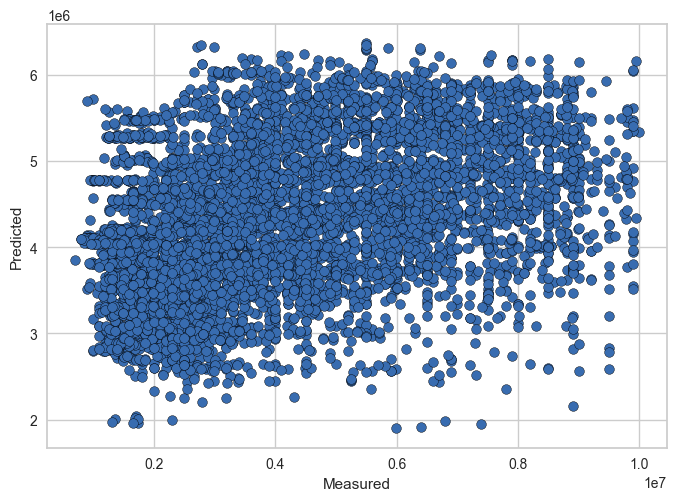

In [233]:
lr = linear_model.LinearRegression()

y_predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y_predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

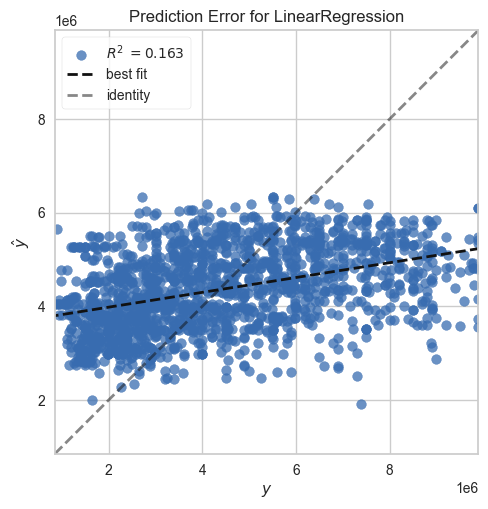

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [234]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError
from yellowbrick.style import set_palette

set_palette('accent')
model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Model 2 - Linear Regression with Scaling

In [157]:
X = data_train[['closest_station_distance', 'num_facility','nearby_supermarkets']]
y = data_train.price
print(X.shape)
print(y.shape)

(6695, 3)
(6695,)


In [158]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [159]:
linreg = LinearRegression()

linreg = linreg.fit(X_train_scaled, y_train)


In [160]:
print("Training set score: {:.3f}".format (linreg.score(X_train_scaled, y_train)))

X_test_scaled = scaler.transform(X_test)
print("Test set score: {:.3f}".format(linreg.score(X_test_scaled, y_test)))

Training set score: 0.155
Test set score: 0.163


In [161]:
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
np.mean(scores)

0.15200083658830504

In [162]:
cross_val_score(LinearRegression(), X_train, y_train, cv=10)

array([0.149, 0.147, 0.158, 0.154, 0.181, 0.132, 0.151, 0.137, 0.095,
       0.214])

In [163]:
np.std(scores)

0.02926404322525153

### Model 2 Result

In [164]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.152 (+/- 0.059)


## Model 3 - Cross Validation with scaler (Use Pipeline)

In [165]:
linreg_pipe = make_pipeline(StandardScaler(),LinearRegression())
scores = cross_val_score(linreg_pipe, X_train, y_train, cv =10)
np.mean(scores), np.std(scores)

(0.15200083658830507, 0.029264043225251484)

In [166]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.152 (+/- 0.059)


In [167]:
#ใช้ค่า X และ y
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.156 (+/- 0.066)


### Model 3 Result

In [168]:
#ใช้ค่า x และ y + scaling โดยใช้ pipeline
linreg_pipe = make_pipeline(StandardScaler(),LinearRegression())
scores = cross_val_score(linreg_pipe, X, y, cv = 10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.156 (+/- 0.066)


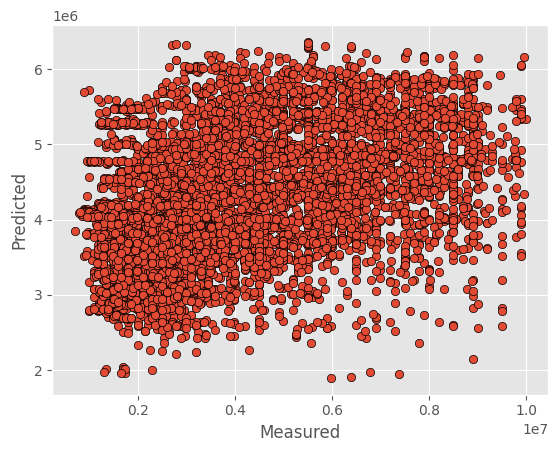

In [169]:
#เปรียบเทียบ y กับ y_predict จากการทำ cross validation
lr = linear_model.LinearRegression()

y_predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y_predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Model 4 - Ridge

In [170]:
#ใช้ alpha เป็น 1
RR = Ridge(alpha=10.0)
RR = RR.fit(X_train, y_train)
y_predict = RR.predict(X_test)

In [171]:
Ridge()

Ridge()

In [172]:
RR.get_params()

{'alpha': 10.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [173]:
# show model parameters
print("RR.coef_: \n {}".format(RR.coef_))
print("RR.intercept_: {}".format(RR.intercept_))

RR.coef_: 
 [ -1372.281  76664.109 141626.565]
RR.intercept_: 2736198.3929804005


In [174]:
print("Training set score: {:.3f}".format(RR.score(X_train, y_train)))
print("Test set score: {:f}".format(RR.score(X_test, y_test)))


Training set score: 0.155
Test set score: 0.162953


### Model 4 Result
alpha ไม่มีผล

In [175]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)

# The mean squared error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained variance score: 1 is perfect prediction
r2_test= r2_score(y_test, y_predict)
print('R2-score: %f' % r2_test)

Mean absolute error: 1629252.429
Mean squared error: 3984646490785.181
R2-score: 0.162953


## Model 5 - Ridge with Scaling

In [176]:
#ทำ scaling แบบ standard scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [177]:
#ใช้ alpha เป็น 1
RR = Ridge(alpha=1.0)
RR = RR.fit(X_train_scaled, y_train)

In [178]:
Ridge()

Ridge()

In [179]:
RR.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [180]:
# show model parameters
print("RR.coef_: \n {}".format(RR.coef_))
print("RR.intercept_: {}".format(RR.intercept_))

RR.coef_: 
 [-338190.291  220238.176  763889.508]
RR.intercept_: 4334230.468034256


In [181]:
#scale test ก่อนหา predict
X_test_scaled = scaler.transform(X_test)
y_predict = RR.predict(X_test_scaled)
# print(y_predict)

In [182]:
print("Training set score: {:.3f}".format(RR.score(X_train_scaled, y_train)))
print("Test set score: {:f}".format(RR.score(X_test_scaled, y_test)))


Training set score: 0.155
Test set score: 0.162949


### Model 5 Result

In [183]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)

# The mean squared error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained variance score: 1 is perfect prediction
r2_test= r2_score(y_test, y_predict)
print('R2-score: %f' % r2_test)

Mean absolute error: 1629264.591
Mean squared error: 3984662560457.218
R2-score: 0.162949


In [184]:
#pipeline
RR_pipe = make_pipeline(StandardScaler(),Ridge())
RR_pipe.fit(X_train, y_train)
print('R2-score: %f' % RR_pipe.score(X_test, y_test))

R2-score: 0.162949


In [185]:
#แบบ scale มาแล้ว (ถ้า scale แล้วค่อย cross validation + model จะทำให้เกิด information leakage)
np.mean(cross_val_score(Ridge(), X_train_scaled, y_train, cv=10))

0.15200114570716888

In [186]:
#ลองใช้ pipeline (ไม่เกิด information leakage)
RR_pipe = make_pipeline(StandardScaler(),Ridge())
scores = cross_val_score(RR_pipe, X_train, y_train, cv = 10)
np.mean(scores), np.std(scores)

(0.15200114837943807, 0.029257577003601782)

In [187]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.152 (+/- 0.059)


## Model 6 - Ridge Regression with Grid-Search and Cross-Validation

In [188]:
np.set_printoptions(suppress=True, precision=3)

In [189]:
#กำหนด alpha เป็นเลข ระหว่าง 0.001-1000
param_grid = {'alpha': np.logspace(-3, 3, 13)}
print(param_grid)

{'alpha': array([   0.001,    0.003,    0.01 ,    0.032,    0.1  ,    0.316,
          1.   ,    3.162,   10.   ,   31.623,  100.   ,  316.228,
       1000.   ])}


In [190]:
grid = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([   0.001,    0.003,    0.01 ,    0.032,    0.1  ,    0.316,
          1.   ,    3.162,   10.   ,   31.623,  100.   ,  316.228,
       1000.   ])},
             return_train_score=True)

In [191]:
best_results = pd.DataFrame(grid.cv_results_)
# print("Best parameter {}".format(grid.cv_results_))
best_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.000925,0.000774,0.000296,0.000205,0.001,{'alpha': 0.001},0.149155,0.147296,0.158476,0.153987,...,0.155035,0.155526,0.152675,0.157508,0.155748,0.157501,0.161457,0.148493,0.155525,0.003177
1,0.000747,0.000405,0.000271,0.000160,0.003162,{'alpha': 0.0031622776601683794},0.149155,0.147296,0.158476,0.153987,...,0.155035,0.155526,0.152675,0.157508,0.155748,0.157501,0.161457,0.148493,0.155525,0.003177
2,0.000646,0.000372,0.000243,0.000177,0.01,{'alpha': 0.01},0.149155,0.147296,0.158476,0.153987,...,0.155035,0.155526,0.152675,0.157508,0.155748,0.157501,0.161457,0.148493,0.155525,0.003177
3,0.000720,0.000378,0.000236,0.000114,0.031623,{'alpha': 0.03162277660168379},0.149155,0.147296,0.158476,0.153987,...,0.155035,0.155526,0.152675,0.157508,0.155748,0.157501,0.161457,0.148493,0.155525,0.003177
4,0.000668,0.000364,0.000237,0.000139,0.1,{'alpha': 0.1},0.149155,0.147296,0.158476,0.153987,...,0.155035,0.155526,0.152675,0.157508,0.155748,0.157501,0.161457,0.148493,0.155525,0.003177


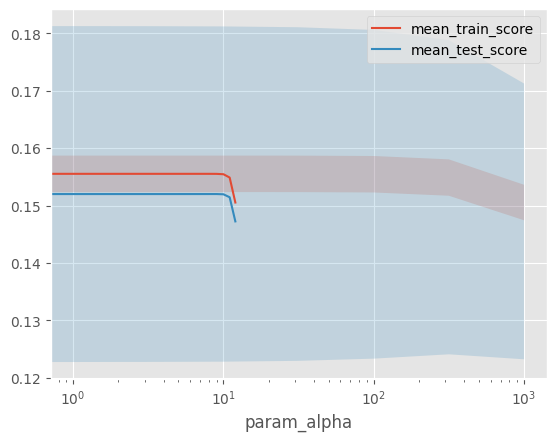

In [192]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.int32),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.int32),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")

In [193]:
print("Best mean CV score: {:.3f}".format(grid.best_score_))

print("Best parameter {}".format(grid.best_params_))

print("test-set : {:.3f}".format(grid.score(X_test_scaled, y_test)))

Best mean CV score: 0.152
Best parameter {'alpha': 31.622776601683793}
test-set : 0.163


In [194]:
grid.best_estimator_

Ridge(alpha=31.622776601683793)

In [195]:
param_grid = {'alpha': np.logspace(1, 3, 30)}
print(param_grid)
grid = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
grid.fit(X_train_scaled, y_train)

{'alpha': array([  10.   ,   11.721,   13.738,   16.103,   18.874,   22.122,
         25.929,   30.392,   35.622,   41.753,   48.939,   57.362,
         67.234,   78.805,   92.367,  108.264,  126.896,  148.735,
        174.333,  204.336,  239.503,  280.722,  329.034,  385.662,
        452.035,  529.832,  621.017,  727.895,  853.168, 1000.   ])}


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([  10.   ,   11.721,   13.738,   16.103,   18.874,   22.122,
         25.929,   30.392,   35.622,   41.753,   48.939,   57.362,
         67.234,   78.805,   92.367,  108.264,  126.896,  148.735,
        174.333,  204.336,  239.503,  280.722,  329.034,  385.662,
        452.035,  529.832,  621.017,  727.895,  853.168, 1000.   ])},
             return_train_score=True)

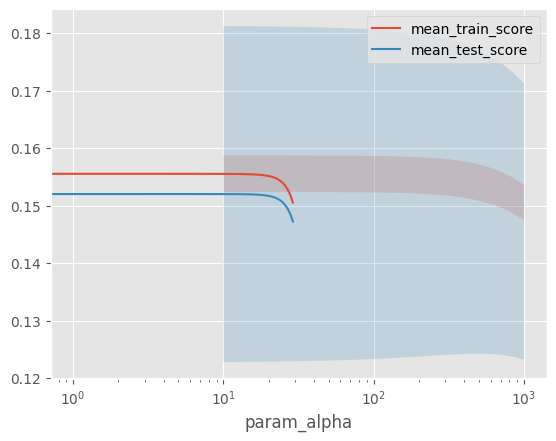

In [196]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.int32),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.int32),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")

In [197]:
print("Best mean CV score: {:.3f}".format(grid.best_score_))

print("Best parameter {}".format(grid.best_params_))

print("test-set : {:f}".format(grid.score(X_test_scaled, y_test)))


Best mean CV score: 0.152
Best parameter {'alpha': 22.122162910704493}
test-set : 0.162902


In [198]:
grid.best_estimator_

Ridge(alpha=22.122162910704493)

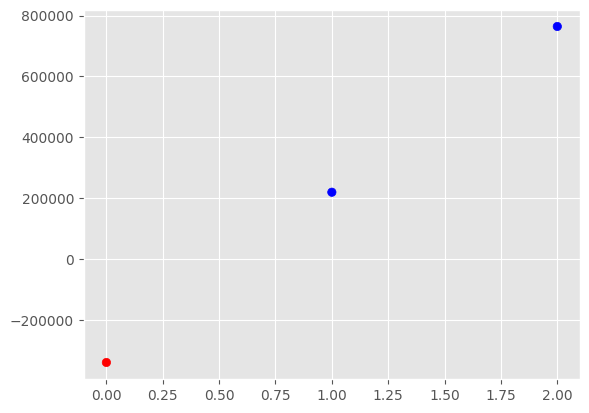

In [199]:
linreg = LinearRegression().fit(X_train_scaled, y_train)
plt.scatter(range(X.shape[1]), linreg.coef_, c=np.sign(linreg.coef_), cmap="bwr_r")

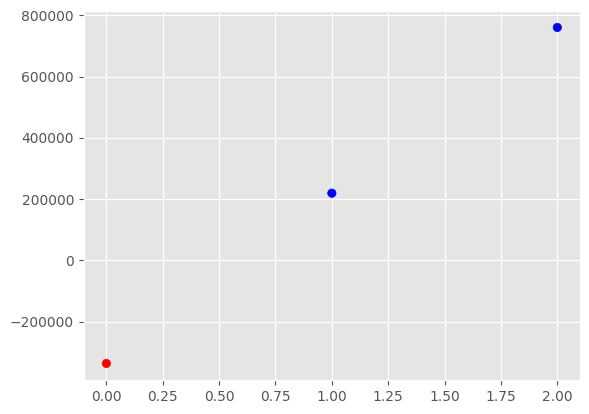

In [200]:
best_ridge = grid.best_estimator_
plt.scatter(range(X.shape[1]), best_ridge.coef_, c=np.sign(best_ridge.coef_), cmap="bwr_r")


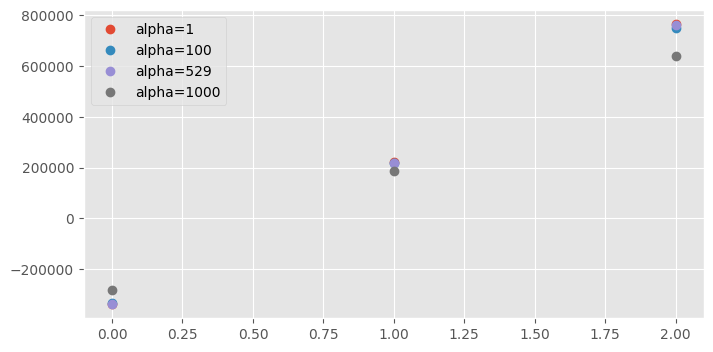

In [201]:
ridge1000 = Ridge(alpha=1000).fit(X_train_scaled, y_train)
ridge100 = Ridge(alpha=100).fit(X_train_scaled, y_train)
ridge1 = Ridge(alpha=1).fit(X_train_scaled, y_train)

plt.figure(figsize=(8, 4))

plt.plot(ridge1.coef_, 'o', label="alpha=1")
plt.plot(ridge100.coef_, 'o', label="alpha=100")
plt.plot(best_ridge.coef_, 'o', label="alpha=529")
plt.plot(ridge1000.coef_, 'o', label="alpha=1000")
plt.legend()

#### Ridge regression with best alpha

In [202]:
RR = grid.best_estimator_
RR = RR.fit(X_train_scaled, y_train)

In [203]:
# show model parameters
print("RR.coef_: \n {}".format(RR.coef_))
print("RR.intercept_: {}".format(RR.intercept_))

RR.coef_: 
 [-336789.399  219429.952  760699.618]
RR.intercept_: 4334230.468034256


In [204]:
X_test_scaled = scaler.transform(X_test)
y_predict = RR.predict(X_test_scaled)
# print(y_predict)

In [205]:
print("Training set score: {:.3f}".format(RR.score(X_train_scaled, y_train)))
print("Test set score: {:f}".format(RR.score(X_test_scaled, y_test)))


Training set score: 0.155
Test set score: 0.162902


In [206]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)

# The mean squared error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained R2-score: 1 is perfect prediction
r2_test= r2_score(y_test, y_predict)
print('R2-score: %f' % r2_test)

Mean absolute error: 1629606.234
Mean squared error: 3984886954576.975
R2-score: 0.162902


In [207]:
LR = Lasso(alpha=1.0)

In [208]:
LR.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [209]:
LR = LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)

In [210]:
# show model parameters
print("LR.coef_: \n {}".format(LR.coef_))
print("LR.intercept_: {}".format(LR.intercept_))

LR.coef_: 
 [ -1372.275  76682.164 141636.033]
LR.intercept_: 2735945.40948427


In [211]:
print("Training set score: {:.3f}".format(LR.score(X_train, y_train)))
print("Test set score: {:.3f}".format(LR.score(X_test, y_test)))

Training set score: 0.155
Test set score: 0.163


In [212]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)


# The mean squared error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained variance score: 1 is perfect prediction
r2_test= r2_score(y_test, y_predict)
print('R2-score: %.3f' % r2_test)

Mean absolute error: 1629248.669
Mean squared error: 3984652454935.642
R2-score: 0.163


## Model 7 - Lasso

In [213]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [214]:
LR = Lasso(alpha=1.0)
LR = LR.fit(X_train_scaled, y_train)

In [215]:
print("LR.coef_: \n {}".format(LR.coef_))
print("LR.intercept_: {}".format(LR.intercept_))

LR.coef_: 
 [-338255.931  220275.64   764040.207]
LR.intercept_: 4334230.468034256


In [216]:
#scale test ก่อนหา predict
X_test_scaled = scaler.transform(X_test)
y_predict = LR.predict(X_test_scaled)
# print(y_predict)

In [217]:
print("Training set score: {:.3f}".format(LR.score(X_train_scaled, y_train)))
print("Test set score: {:f}".format(LR.score(X_test_scaled, y_test)))

# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_predict)
print("Mean absolute error: %.3f" % mae_test)

# The mean squared error
mse_test=mean_squared_error(y_test, y_predict)
print("Mean squared error: %.3f" % mse_test)

# R2-score: Explained variance score: 1 is perfect prediction
r2_test= r2_score(y_test, y_predict)
print('R2-score: %f' % r2_test)

Training set score: 0.155
Test set score: 0.162952
Mean absolute error: 1629248.777
Mean squared error: 3984652473447.417
R2-score: 0.162952


In [218]:
LR_pipe = make_pipeline(StandardScaler(),Lasso())
LR_pipe.fit(X_train, y_train)
LR_pipe.score(X_test, y_test)

0.16295159098090817

In [219]:
LR_pipe = make_pipeline(StandardScaler(),Lasso())
scores = cross_val_score(LR_pipe, X_train, y_train, cv = 10)
np.mean(scores), np.std(scores)

(0.15200083740964726, 0.029263988425515218)

In [220]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.152 (+/- 0.059)


# Conclusion

จาก model ทั่งหมด 6 แบบ จะพบว่าค่า R-Square ของทุกๆแบบจะไม่มี model ไหนเกิน 0.162 จะมี model Linear Regression OLS ที่ได้ถึง 0.163 และ Model ที่คะแนนต่ำสุดคิอ Linear with scaling

ซึ่งจากที่คะแนนที่ออกมา อาจจะพอสรุปว่า ข้อมูลที่มีนี้อาจะไม่เหมาะกับการทำ prediction ควรหาข้อมูลที่เป็น catagory มาเสริม

# Extra research

In [221]:
from sklearn.ensemble import RandomForestRegressor
# Split data into features and target variable
X = data_train.drop('price', axis=1)
y = data_train['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 814504.1104648218


In [222]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the number of folds (k)
k = 5

# Create a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store RMSE scores for each fold
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train your model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE for this fold
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {average_rmse}')


Average RMSE: 846892.4032207432
